# Proyecto: Predicción de tipo de tumor en cáncer de Seno

### Reconocimiento de patrones

#### ***Estudiante: Sergio Méndez Mendoza***

El objetivo de este notebook es predecir el diagnóstico de cáncer de seno a partir de características extraídas de imágenes de células tumorales, mediante la implementación y evaluación de distintos modelos de clasificación supervisada. Utilizando un conjunto de datos del UCI Machine Learning Repository, se busca predecir si un tumor es benigno o maligno a partir de 30 atributos descritos en el estudio de Street, Wolberg y Mangasarian (1993). Para ello, se aplicarán y compararán los algoritmos SVM, K-vecinos, árboles de decisión, Random Forest, redes neuronales y Gradient Boosting, así como un modelo de ensamble mediante VotingClassifier. Se utilizarán métricas de desempeño como precisión, F1-score y exactitud para analizar y comentar los resultados de cada clasificador.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
import os

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


# Preprocesing Data

## Snakes
A snake is a deformable spline which seeks to minimize an energy function defined over the arclength of a closed curve the energy function is defined in such away that the minimum value occurs when the curve accurately corresponds to the boundary of a cell nucleus

## Nuclear features

| <!-- -->      | <!-- -->        |
|:-------------:|:---------------:|
| Radius        | Te radius of an individual nucleus is measured by averaging the length of the radial line segments defined by the centroid of the snake and the individual snale points.|
| Perimeter     | The total distance between the snake points constitutes the nulear perimeter.|
| Area          | Nuclear area is measured simply by counting the number of pixels on the interior of the snake and adding one-half of the pixels in the perimeter.    |
| Compactness   | Perimeter and area are combined to give a measure of the compactness of the cell nuclei using the formula $\frac{{perimeter}^2}{area}$.   |
| Smoothness    | The difference between the length of a radial line and the mean lenth of the lines surrounding it. |
| Concavity     | Chords between non-adjacent snake points and measure the extent to which the actual boundary of the nucleus lies on the inside of each chord (Smaller chords better capture small concavities).  |
| Concave Points | Similar to Concavity but measures only the number, rather than the magnitude, of contour concavities.  |
| Symmetry      | In order to measure symetry, the major axis, or longest chord through the center, is found. Then measure the length difference between lines perpendicular to the major axis to the cell boundary in both directions.    |
| Fractal Dimension| Fractal Dimension is estimated using Mandelbrot's coastline method; higher values indicate more irregular contours and higher malignancy probability.      |
| Texture       | Texture is measure by finding the variance of the gray scale intensities in the component pixels.   |

In [10]:
# load data
df = pd.read_csv("data.csv")
display(df.head())

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
df.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [5]:
def count_columns(df_tmp):
    total_columns = 0
    for column in df_tmp.columns:
        total_columns+=1
    print('Total columns ', total_columns)

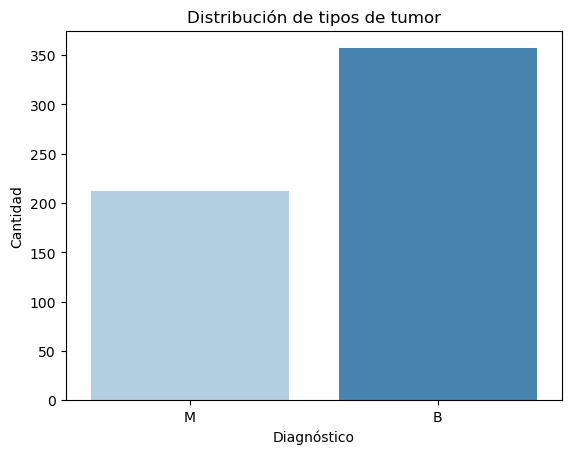

In [17]:
sns.countplot(x='diagnosis', data=df, hue='diagnosis', palette='Blues', legend = False)
plt.title('Distribución de tipos de tumor')
plt.xlabel('Diagnóstico')
plt.ylabel('Cantidad')
plt.show()

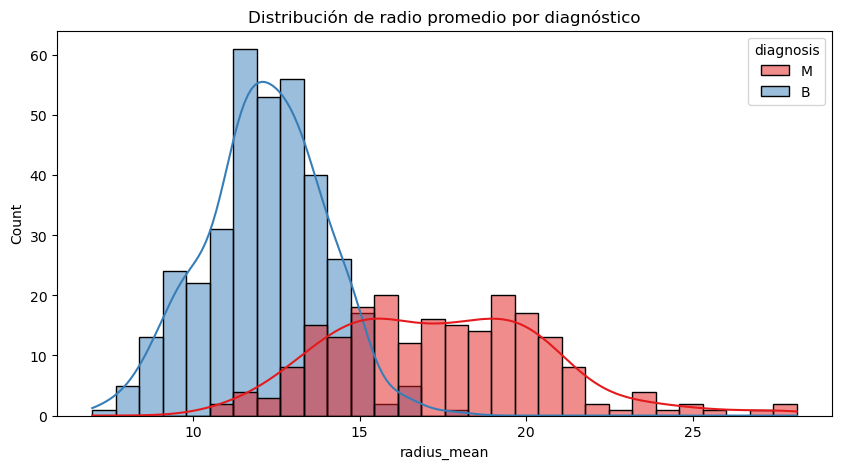

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='radius_mean', hue='diagnosis', bins=30, kde=True, palette='Set1')
plt.title('Distribución de radio promedio por diagnóstico')
plt.show()

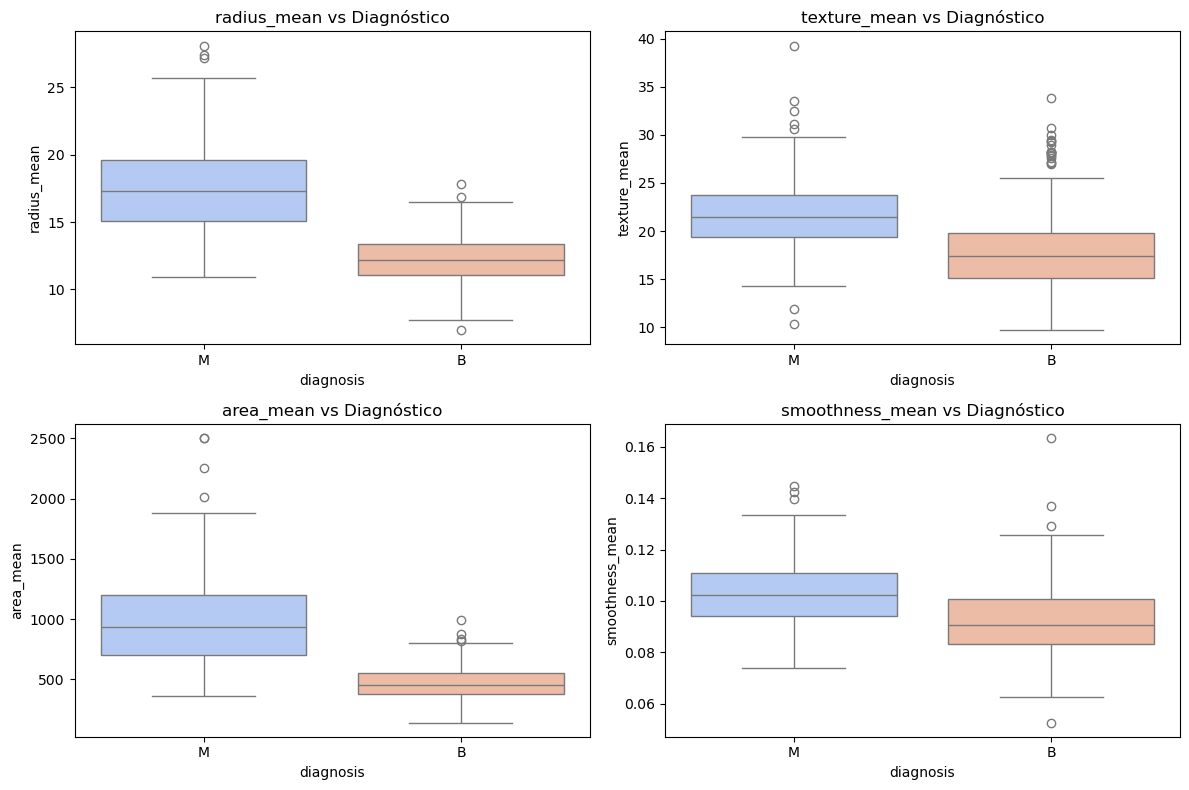

In [20]:
features = ['radius_mean', 'texture_mean', 'area_mean', 'smoothness_mean']

plt.figure(figsize=(12, 8))
for i, col in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='diagnosis', y=col, hue='diagnosis', data=df, palette='coolwarm', legend= False)
    plt.title(f'{col} vs Diagnóstico')
plt.tight_layout()
plt.show()

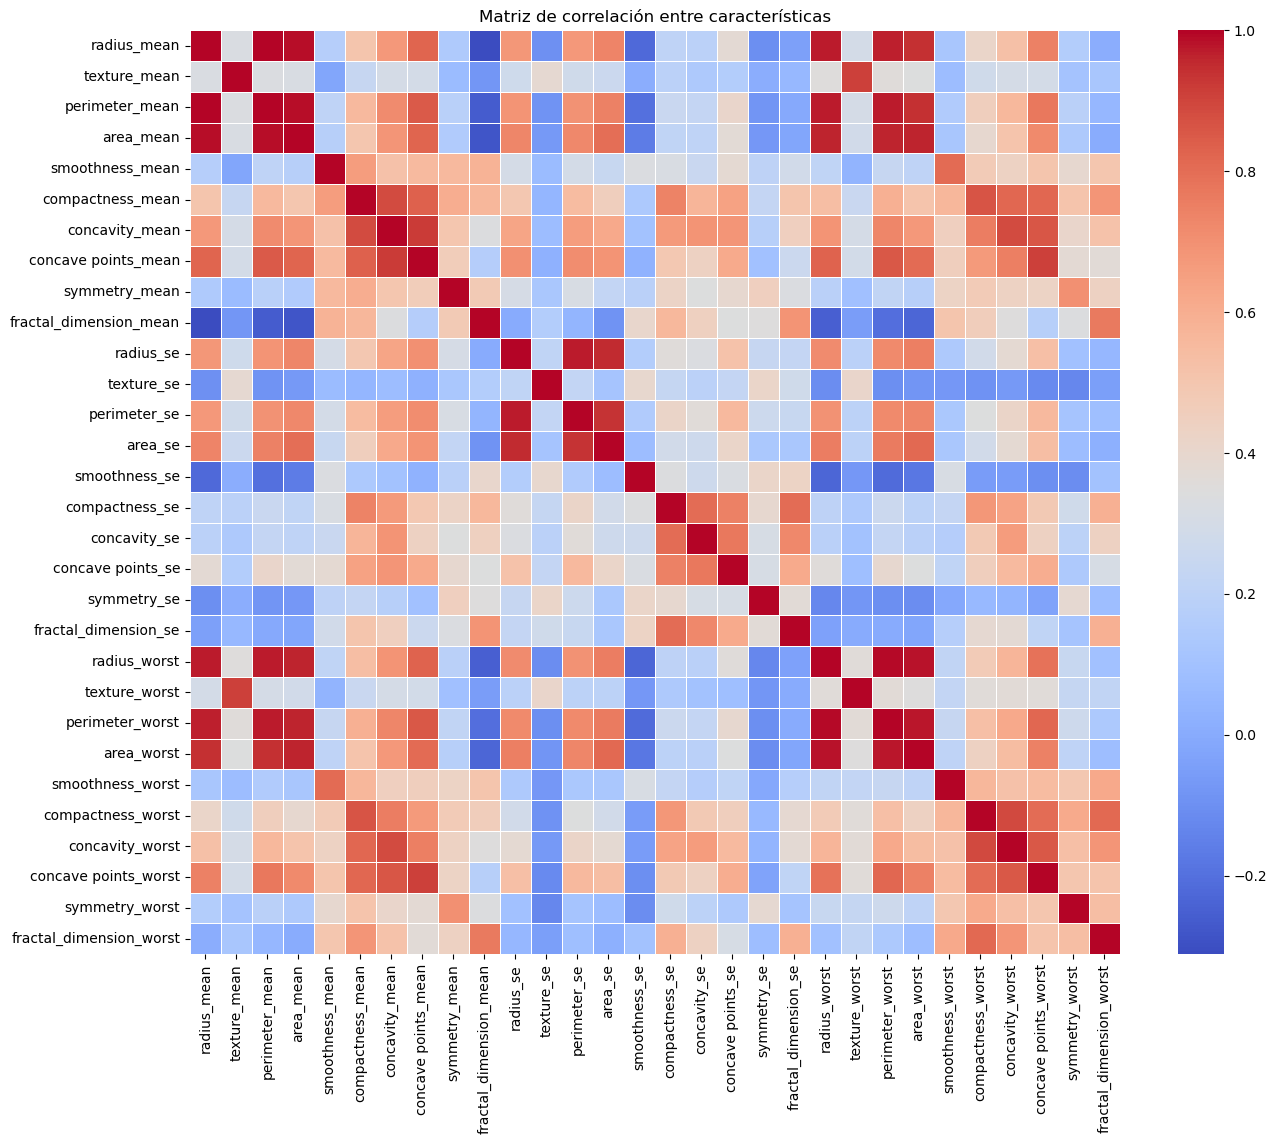

In [21]:
plt.figure(figsize=(15, 12))
corr_matrix = df.drop(['id', 'diagnosis', 'Unnamed: 32'], axis=1).corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Matriz de correlación entre características')
plt.show()

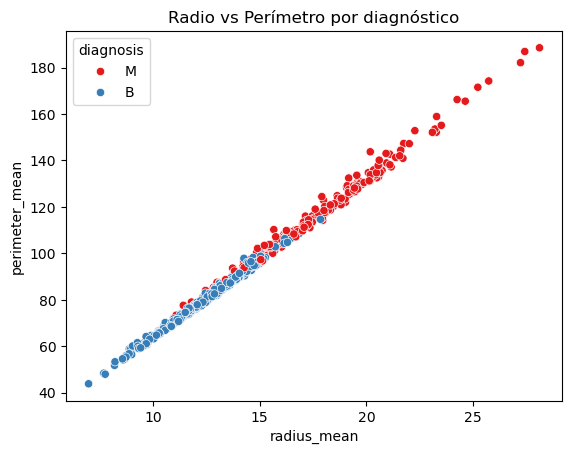

In [22]:
sns.scatterplot(data=df, x='radius_mean', y='perimeter_mean', hue='diagnosis', palette='Set1')
plt.title('Radio vs Perímetro por diagnóstico')
plt.show()

## Selección de caracteristicas

In [6]:
count_columns(df)

Total columns  33


In [7]:
df["Unnamed: 32"]

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
564   NaN
565   NaN
566   NaN
567   NaN
568   NaN
Name: Unnamed: 32, Length: 569, dtype: float64

In [8]:
df_1 = df.drop({'Unnamed: 32', 'id'}, axis=1)

In [9]:
df_1.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [10]:
count_columns(df_1)

Total columns  31


In [11]:
## Variable a predecir diagnosis
X = df_1.drop('diagnosis',axis=1)
y = df_1['diagnosis'].map({'M': 1,'B': 0})

In [12]:
display(X)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [13]:
display(y)

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

In [14]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x).squeeze()

In [15]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
os.environ['OMP_NUM_THREADS'] = '1'
svm = SVC()
knn = KNeighborsClassifier(
    n_neighbors=5,
    algorithm='brute',     # Evita tree algorithms problemáticos
    metric='manhattan',    # Cambia métrica (a veces euclidean causa problemas)
    n_jobs=1
)
dt  = DecisionTreeClassifier()
rf  = RandomForestClassifier()
gb  = GradientBoostingClassifier()
mlp  = MLP(X_train.shape[1]).to(device)

## Entrenamiento y evaluación

In [18]:
def train_model(model,X_train, X_test ,y_train, y_test):
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 4. Entrenar
    print("Entrenando modelo...")
    for epoch in range(100):
        model.train()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Imprimir progreso
        if (epoch + 1) % 20 == 0:
            model.eval()
            with torch.no_grad():
                test_outputs = model(X_test)
                test_loss = criterion(test_outputs, y_test)
                test_pred = (test_outputs > 0.5).float()
                test_acc = (test_pred == y_test).float().mean()
            
            print(f'Época {epoch+1}: Train Loss: {loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    return model

In [19]:
X_train_t = torch.FloatTensor(X_train).to(device)
X_test_t = torch.FloatTensor(X_test).to(device)
y_train_t = torch.FloatTensor(y_train.values).to(device)
y_test_t = torch.FloatTensor(y_test.values).to(device)

In [20]:
def plot_classification_report(y_true, y_pred, target_names=None, name='' ,figsize=(10, 4)):
    """
    Crea heatmap de métricas y matriz de confusión del classification report
    """
    # Obtener el classification report como diccionario
    report = classification_report(y_true, y_pred, output_dict=True)
    # Preparar datos para graficar
    if target_names is None:
        classes = ['Class 0', 'Class 1']
    else:
        classes = target_names
    
    metrics = ['precision', 'recall', 'f1-score']
    
    # Extraer valores para cada clase
    class_0_values = [report['0'][metric] for metric in metrics]
    class_1_values = [report['1'][metric] for metric in metrics]
    
    subtitle = f'Classification Report {name}'
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(subtitle, fontsize=16, fontweight='bold')
    
    # 1. Heatmap de métricas
    metrics_data = np.array([class_0_values, class_1_values])
    sns.heatmap(metrics_data, annot=True, fmt='.3f', 
                xticklabels=metrics, yticklabels=classes,
                cmap='Blues', ax=axes[0], cbar_kws={'label': 'Score'})
    axes[0].set_title('Heatmap de Métricas')
    
    # 2. Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes,
                ax=axes[1])
    axes[1].set_title('Matriz de Confusión')
    axes[1].set_xlabel('Predicho')
    axes[1].set_ylabel('Real')
    
    plt.tight_layout()
    plt.show()
    
    # Imprimir métricas generales
    print(f"Accuracy: {report['accuracy']:.3f}")
    print(f"Macro Avg - Precision: {report['macro avg']['precision']:.3f}")
    print(f"Macro Avg - Recall: {report['macro avg']['recall']:.3f}")
    print(f"Macro Avg - F1-Score: {report['macro avg']['f1-score']:.3f}")


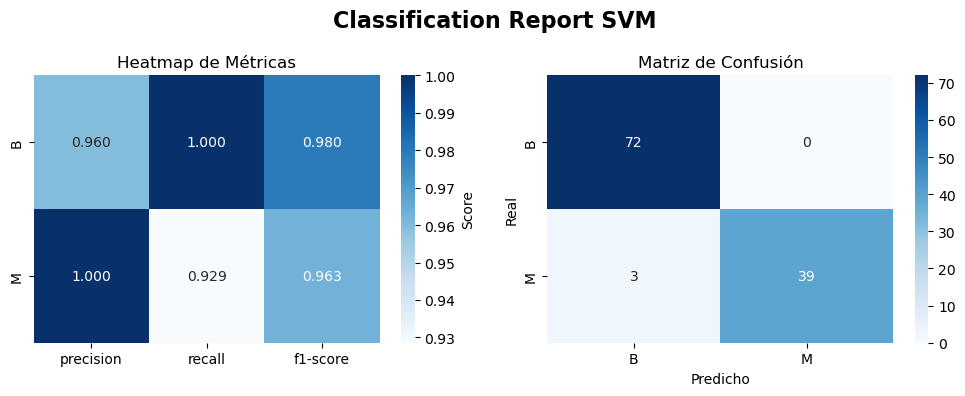

Accuracy: 0.974
Macro Avg - Precision: 0.980
Macro Avg - Recall: 0.964
Macro Avg - F1-Score: 0.971


In [21]:
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
plot_classification_report(y_test,y_pred,['B', 'M'],"SVM")

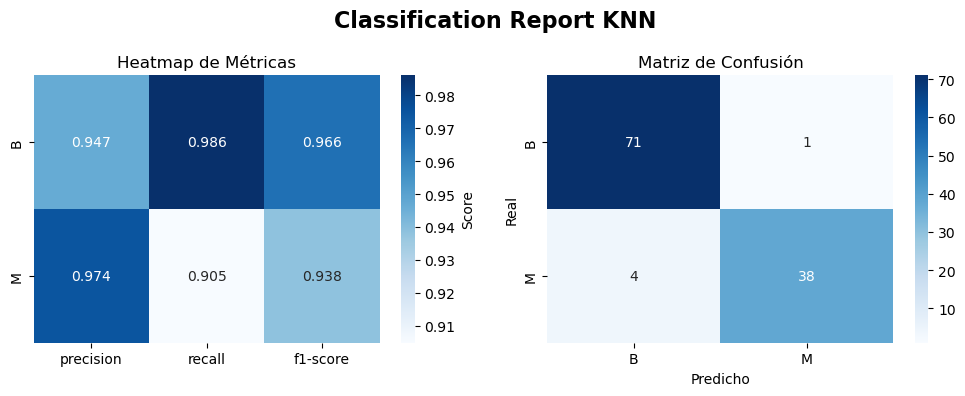

Accuracy: 0.956
Macro Avg - Precision: 0.961
Macro Avg - Recall: 0.945
Macro Avg - F1-Score: 0.952


In [22]:
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
plot_classification_report(y_test,y_pred,['B', 'M'],"KNN")

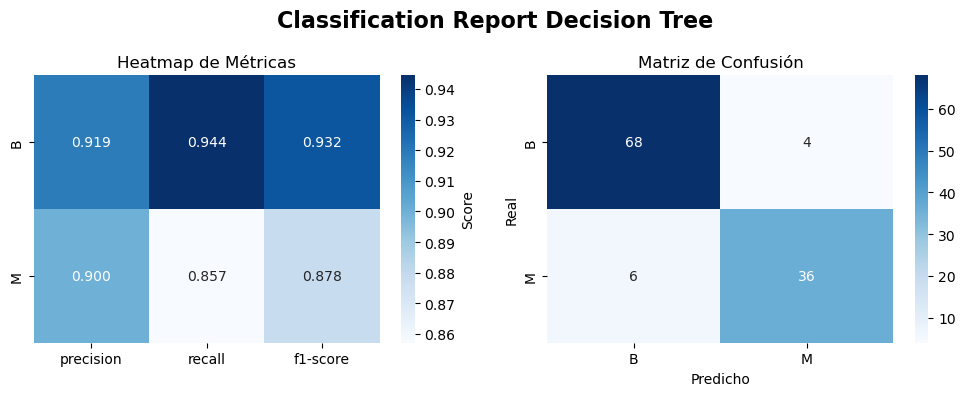

Accuracy: 0.912
Macro Avg - Precision: 0.909
Macro Avg - Recall: 0.901
Macro Avg - F1-Score: 0.905


In [23]:
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
plot_classification_report(y_test,y_pred,['B', 'M'],"Decision Tree")

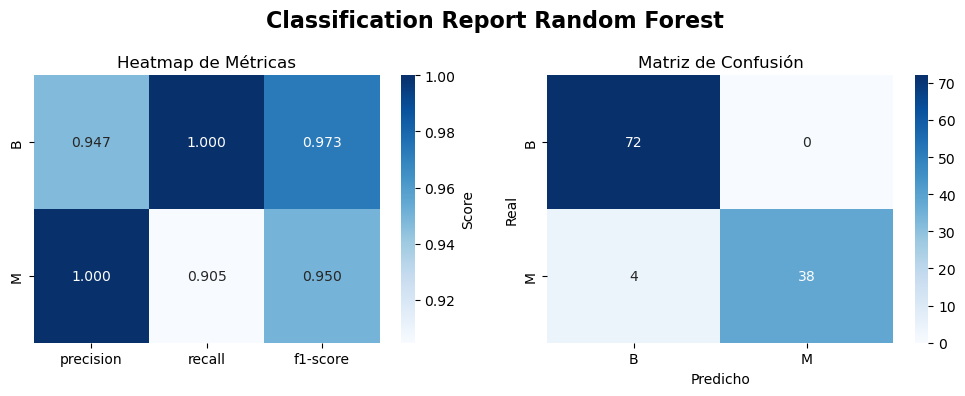

Accuracy: 0.965
Macro Avg - Precision: 0.974
Macro Avg - Recall: 0.952
Macro Avg - F1-Score: 0.961


In [24]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
plot_classification_report(y_test,y_pred,['B', 'M'],"Random Forest")

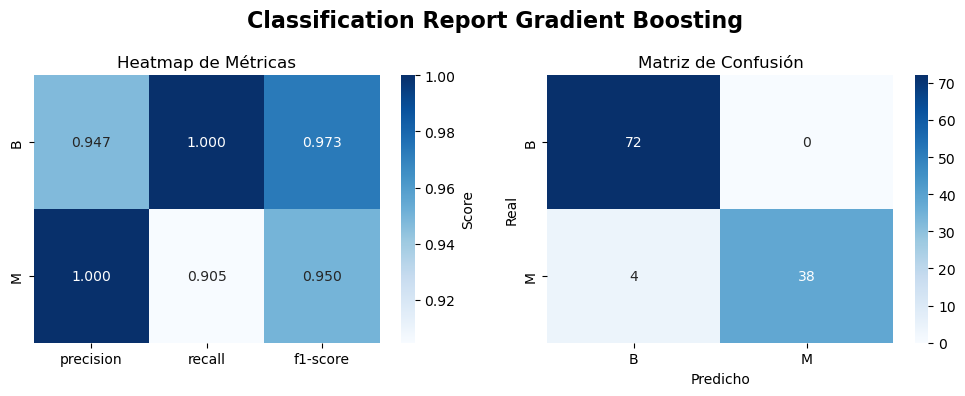

Accuracy: 0.965
Macro Avg - Precision: 0.974
Macro Avg - Recall: 0.952
Macro Avg - F1-Score: 0.961


In [25]:
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
plot_classification_report(y_test,y_pred,['B', 'M'],"Gradient Boosting")

In [26]:
mlp = train_model(mlp, X_train_t, X_test_t, y_train_t, y_test_t)

# 5. Evaluación final
mlp.eval()
with torch.no_grad():
    y_pred_tensor = mlp(X_test_t)
    y_pred = (y_pred_tensor > 0.5).float().cpu().numpy()
    y_true = y_test_t.cpu().numpy()

accuracy = accuracy_score(y_true, y_pred)
print(f"\nPrecisión final: {accuracy:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred))

Entrenando modelo...
Época 20: Train Loss: 0.3590, Test Loss: 0.3219, Test Acc: 0.9211
Época 40: Train Loss: 0.1174, Test Loss: 0.0886, Test Acc: 0.9649
Época 60: Train Loss: 0.0594, Test Loss: 0.0644, Test Acc: 0.9825
Época 80: Train Loss: 0.0450, Test Loss: 0.0737, Test Acc: 0.9737
Época 100: Train Loss: 0.0361, Test Loss: 0.0904, Test Acc: 0.9737

Precisión final: 0.9737

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        72
         1.0       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



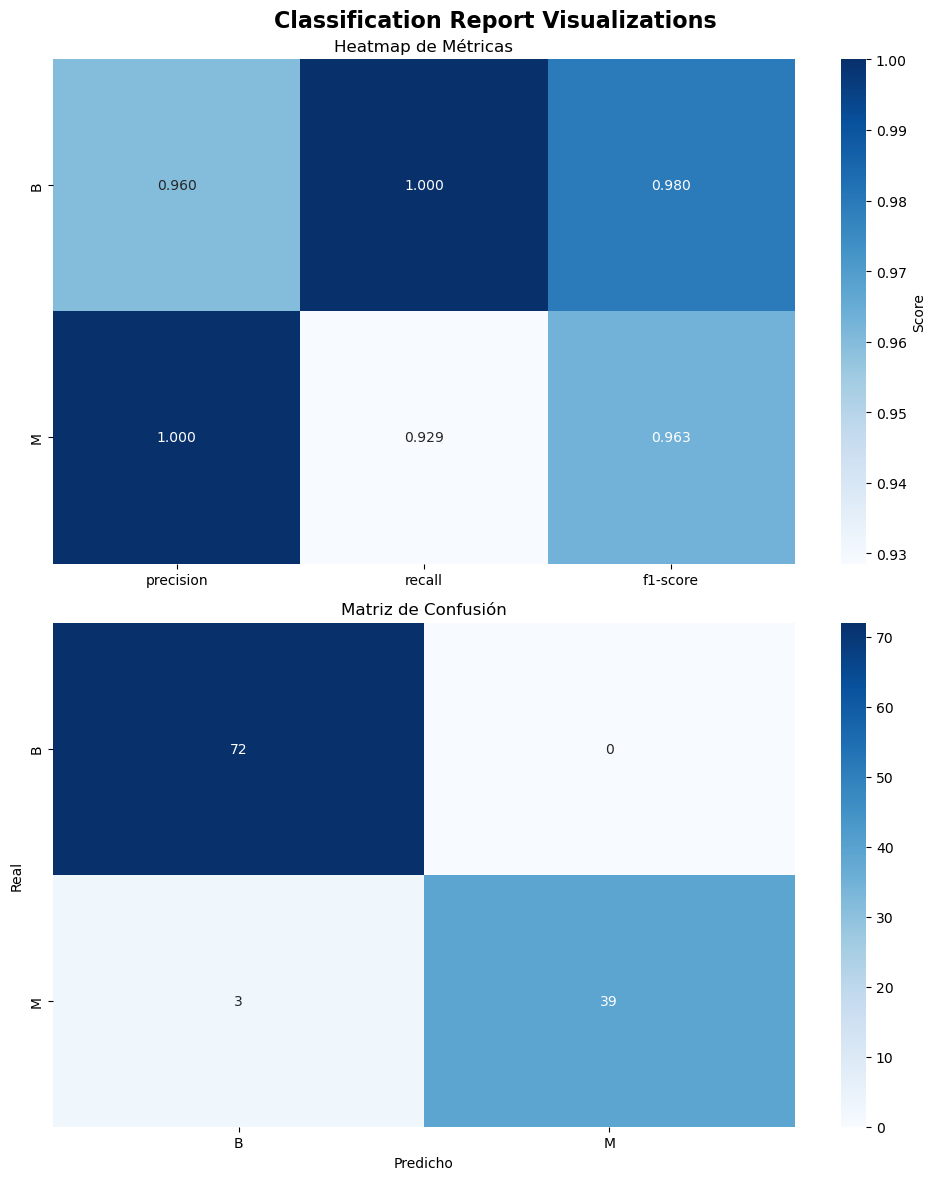

Accuracy: 0.974
Macro Avg - Precision: 0.980
Macro Avg - Recall: 0.964
Macro Avg - F1-Score: 0.971


In [27]:
report = classification_report(y_true, y_pred, output_dict=True)

target_names=None    
# Preparar datos para graficar
if target_names is None:
    classes = ['B', 'M']
else:
    classes = target_names

metrics = ['precision', 'recall', 'f1-score']

# Extraer valores para cada clase
class_0_values = [report['0.0'][metric] for metric in metrics]
class_1_values = [report['1.0'][metric] for metric in metrics]

fig, axes = plt.subplots(2, 1, figsize=(10,12))
fig.suptitle('Classification Report Visualizations', fontsize=16, fontweight='bold')

# 1. Heatmap de métricas
metrics_data = np.array([class_0_values, class_1_values])
sns.heatmap(metrics_data, annot=True, fmt='.3f', 
            xticklabels=metrics, yticklabels=classes,
            cmap='Blues', ax=axes[0], cbar_kws={'label': 'Score'})
axes[0].set_title('Heatmap de Métricas')

# 2. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes,
            ax=axes[1])
axes[1].set_title('Matriz de Confusión')
axes[1].set_xlabel('Predicho')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

# Imprimir métricas generales
print(f"Accuracy: {report['accuracy']:.3f}")
print(f"Macro Avg - Precision: {report['macro avg']['precision']:.3f}")
print(f"Macro Avg - Recall: {report['macro avg']['recall']:.3f}")
print(f"Macro Avg - F1-Score: {report['macro avg']['f1-score']:.3f}")

## Crear un ensamble

In [28]:
# Crear un ensamble de votación
voting_clf = VotingClassifier(
    estimators=[
        ('svm', svm),
        ('knn', knn),
        ('dt', dt),
        ('rf', rf),
        ('gb', gb)
    ],
    voting='hard'
)

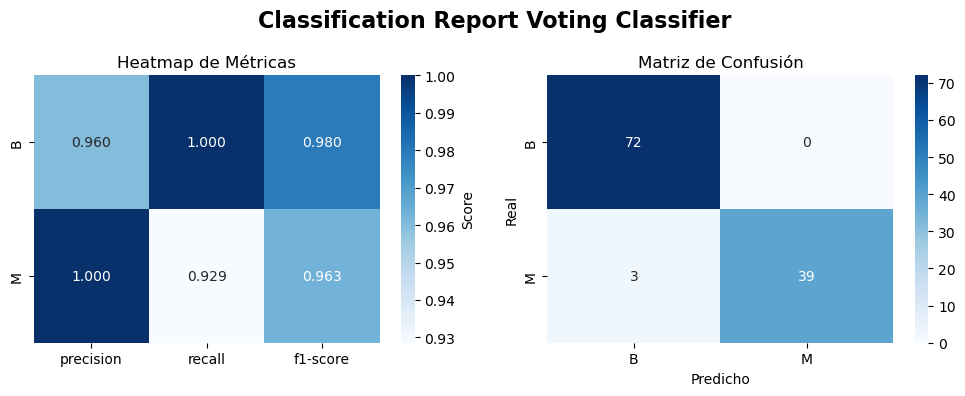

Accuracy: 0.974
Macro Avg - Precision: 0.980
Macro Avg - Recall: 0.964
Macro Avg - F1-Score: 0.971


In [29]:
# Entrenar y evaluar el ensamble
voting_clf.fit(X_train, y_train)
y_pred_ensemble = voting_clf.predict(X_test)
plot_classification_report(y_test,y_pred_ensemble,['B', 'M'],'Voting Classifier')

### Discusión

Los resultados muestran que todos los modelos utilizados fueron capaces de clasificar correctamente los tumores en su mayoría, pero algunos destacaron más que otros. El modelo SVM fue el que obtuvo el mejor desempeño general, con una precisión del 97.4% y métricas muy equilibradas, lo que indica que logró diferenciar bien entre tumores benignos y malignos.

El MLP también alcanzó un rendimiento muy alto, con una precisión final del 97.4%, y mostró una buena evolución durante el entrenamiento. Esto demuestra que las redes neuronales pueden aprender patrones complejos en los datos de forma efectiva.

KNN, Random Forest y Gradient Boosting lograron buenos resultados, con una precisión entre el 95% y el 96.5%. Aunque no superaron a SVM o MLP, siguen siendo modelos muy válidos para este tipo de tareas.

El Árbol de decisión fue el modelo con menor desempeño (91.2%), posiblemente por su tendencia a sobreajustarse a los datos. Sin embargo, cuando se utiliza en conjunto con otros árboles, como en Random Forest, su rendimiento mejora notablemente.

El modelo de ensamble con VotingClassifier combinó las predicciones de varios clasificadores y logró igualar la precisión de SVM, confirmando que combinar modelos puede ser una estrategia útil para mejorar la estabilidad del sistema.

### Conclusión

Este estudio confirma que es posible predecir con alta precisión el tipo de tumor en cáncer de seno usando modelos de aprendizaje automático. Los modelos SVM y MLP fueron los que mejores resultados obtuvieron, seguidos por Random Forest, Gradient Boosting y KNN. El uso de modelos de ensamble también resultó efectivo, aunque no superó al mejor modelo individual.

En general, los resultados son muy positivos y demuestran el valor que pueden tener estas herramientas en el apoyo al diagnóstico médico. A futuro, se podrían probar estos modelos con otros conjuntos de datos o en situaciones más cercanas al entorno clínico para validar su utilidad en la práctica.